<a href="https://colab.research.google.com/github/txnishq28/Stock-Predictor-Model/blob/main/Stock_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance seaborn scikit-learn

In [4]:
from google.colab import files
uploaded = files.upload()



Saving Stock_Price_Dataset.csv to Stock_Price_Dataset.csv


In [5]:
import pandas as pd

# Load the CSV into a DataFrame
df = pd.read_csv("Stock_Price_Dataset.csv")

# View the first few rows
df.head()


,Stock,Date,Open,Price,Risk
0,AAPL,2023-07-03,143.44,144.81,medium
1,AAPL,2023-07-04,152.98,154.90,medium
2,AAPL,2023-07-05,153.10,152.65,medium
3,AAPL,2023-07-06,162.09,158.53,medium
4,AAPL,2023-07-07,160.78,162.31,medium


In [7]:
### Coverting Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

###  Sorting
df = df.sort_values('Date')


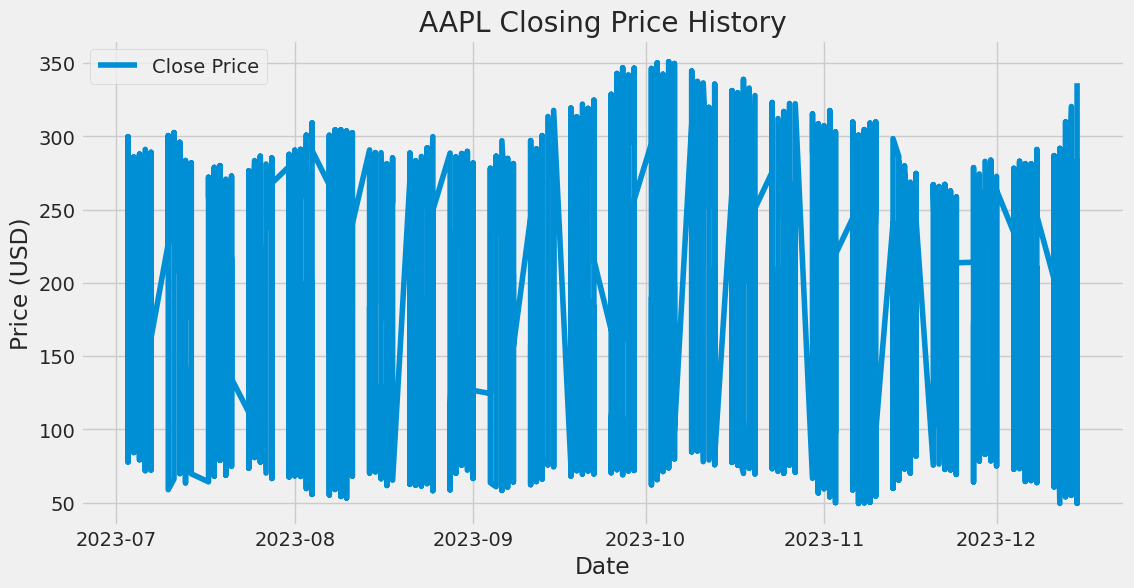

In [8]:
### Visualize the Closing price
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Price'], label='Close Price')
plt.title("AAPL Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [10]:
### Filtering the Price Column for modeling
data = df.filter(['Price'])
dataset = data.values  # convert to numpy array

# 95% training data
import numpy as np
training_data_len = int(np.ceil(len(dataset) * 0.95))


In [11]:
### Scaling the Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [13]:
### Training the Data for LSTM

train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape: [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [17]:
### Now Lets Build the Model
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Initialize the model
model = Sequential()

# First LSTM layer (return sequences so it can go into another LSTM)
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Second LSTM layer
model.add(LSTM(50, return_sequences=False))

# Dense layers
model.add(Dense(25))
model.add(Dense(1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [16]:
model.fit(x_train, y_train, batch_size=1, epochs=5)


Epoch 1/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 0.0797
Epoch 2/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.0698
Epoch 3/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.0710
Epoch 4/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0672
Epoch 5/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0668


In [18]:
# Create test data
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]  # actual prices

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


In [19]:
### Create the test data
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]  ### actual price values (not scaled)

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

### Convert and reshape for LSTM
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  ### unscale the predictions


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)


RMSE: 186.4919307704136


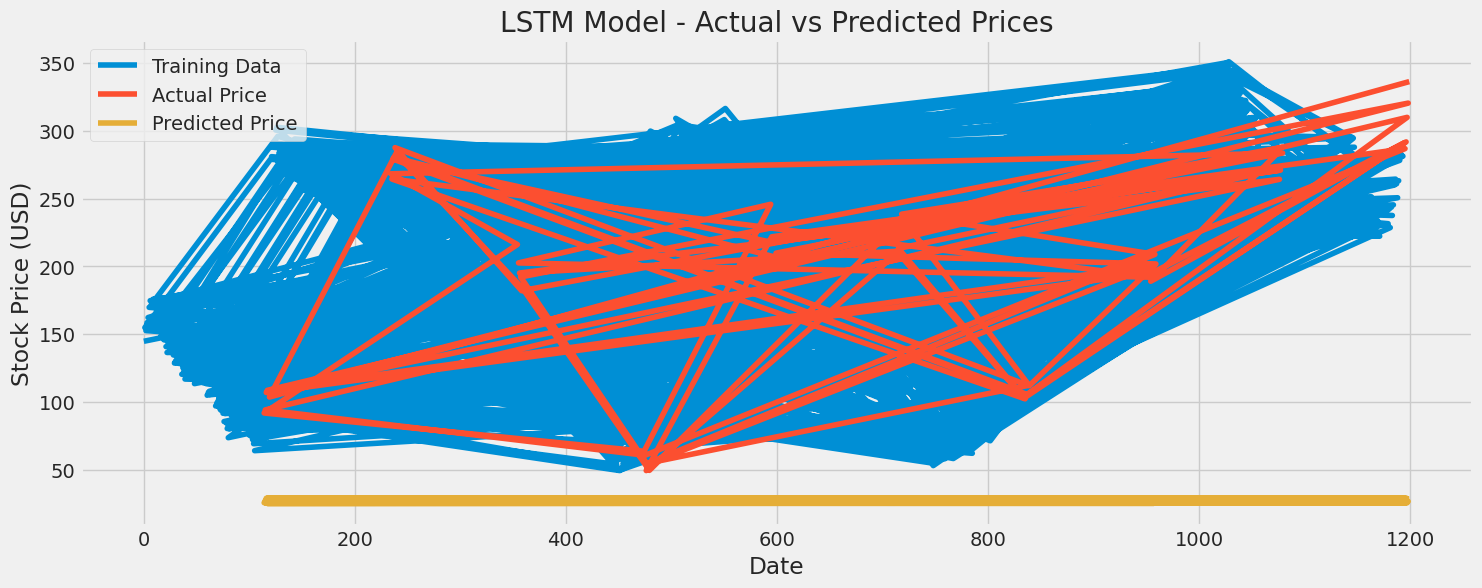

In [21]:
# Recreate the original 'data' DataFrame and split it
train = data[:training_data_len]
valid = data[training_data_len:].copy()

# Add the predictions to the valid set
valid['Predictions'] = predictions

# Plot everything
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.title('LSTM Model - Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.plot(train['Price'], label='Training Data')
plt.plot(valid['Price'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')
plt.legend()
plt.show()


In [22]:
valid.tail(10)



,Price,Predictions
1079,283.63,27.633129
599,209.81,27.339613
959,201.85,27.087584
839,112.08,26.880074
719,235.06,27.085165
479,49.60,27.051899
359,183.65,27.655090
239,283.32,28.111668
119,103.65,28.061201
1199,336.31,28.418911


In [23]:
# Start with last 60 days from the scaled data
last_60_days = scaled_data[-60:]
future_predictions = []

input_sequence = last_60_days.reshape(1, 60, 1)

# Predict next 7 days
for _ in range(7):
    next_price = model.predict(input_sequence)[0][0]
    future_predictions.append(next_price)

    # Update the input sequence: drop the first, add the new one
    input_sequence = np.append(input_sequence[:, 1:, :], [[[next_price]]], axis=1)

# Reverse the scaling to get real price values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Display the results
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Day 1: $28.03
Day 2: $28.44
Day 3: $29.35
Day 4: $30.60
Day 5: $32.07
Day 6: $33.67
Day 7: $35.31


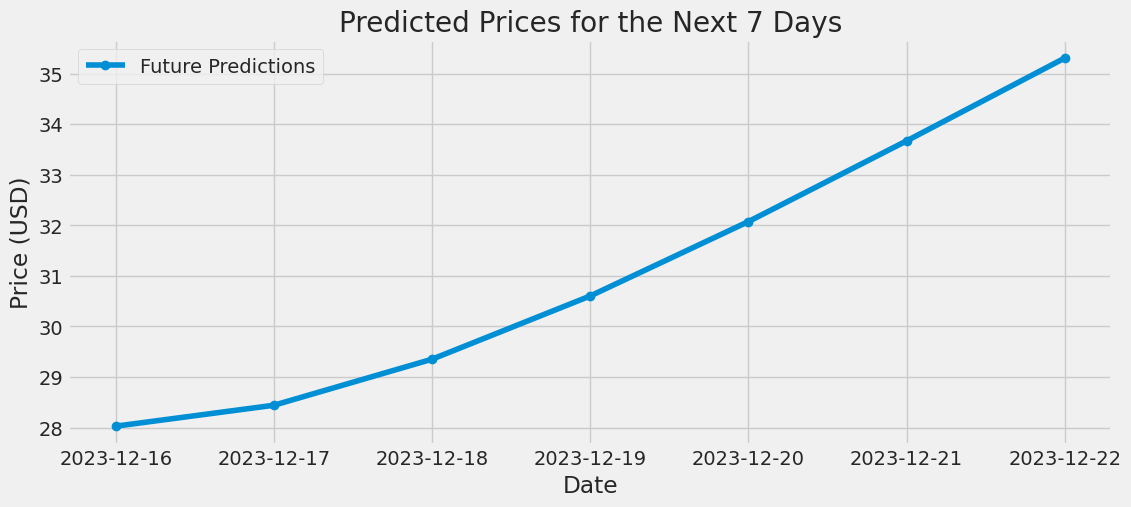

In [24]:
import datetime

last_date = df['Date'].iloc[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 8)]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_predictions, marker='o', label='Future Predictions')
plt.title('Predicted Prices for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


In [26]:
from google.colab import files
uploaded = files.upload()



Saving Stock_Price_Dataset.csv to Stock_Price_Dataset (1).csv


In [27]:
import pandas as pd

# Use the actual filename you uploaded (from above)
df = pd.read_csv("Stock_Price_Dataset.csv")  # no /mnt/data here
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Check available stocks
df['Stock'].unique()


array(['AAPL', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'BABA', 'NFLX',
       'JPM', 'MSFT'], dtype=object)

In [31]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Dropdown for stock selection
stock_dropdown = widgets.Dropdown(
    options=df['Stock'].unique().tolist(),
    description='Select Stock:',
    value=df['Stock'].unique()[0],
    style={'description_width': 'initial'}
)

# Button to trigger prediction
run_button = widgets.Button(description='Run Prediction 🚀', button_style='success')

# Output area to display results
output = widgets.Output()

# Display all
display(stock_dropdown, run_button, output)



Dropdown(description='Select Stock:', options=('AAPL', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'BABA', 'NFLX'…

Button(button_style='success', description='Run Prediction 🚀', style=ButtonStyle())

Output()

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import datetime

def predict_next_7_days(selected_stock):
    print(f"📈 Predicting future prices for: {selected_stock}")

    # Filter stock data
    stock_df = df[df['Stock'] == selected_stock].copy()
    stock_df = stock_df.sort_values('Date')

    # Use only closing price
    data = stock_df[['Price']]
    dataset = data.values

    # Scale and split
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    training_data_len = int(len(dataset) * 0.95)

    train_data = scaled_data[:training_data_len]
    x_train, y_train = [], []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build and train LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=0)

    # Predict next 7 days
    last_60 = scaled_data[-60:]
    input_seq = last_60.reshape(1, 60, 1)
    future_preds = []

    for _ in range(7):
        pred = model.predict(input_seq, verbose=0)[0][0]
        future_preds.append(pred)
        input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

    future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

    # Create future dates
    last_date = stock_df['Date'].iloc[-1]
    future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 8)]

    # Plot predictions
    plt.figure(figsize=(12,5))
    plt.plot(future_dates, future_preds, marker='o', label='Future Predictions')
    plt.title(f'{selected_stock} - Predicted Prices (Next 7 Days)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print values
    for i, price in enumerate(future_preds, 1):
        print(f"Day {i}: ${price[0]:.2f}")


📈 Predicting future prices for: NFLX


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


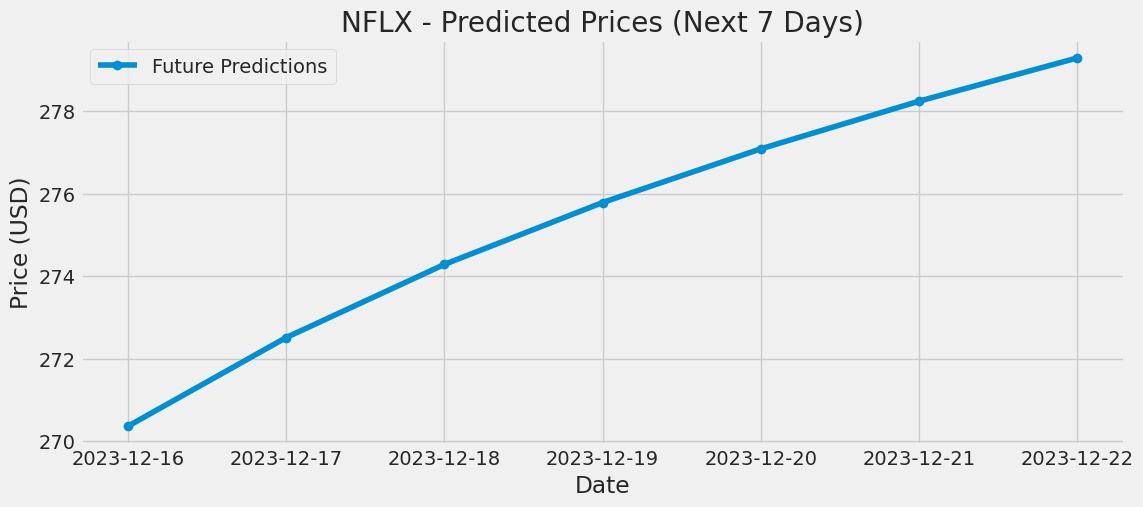

Day 1: $270.36
Day 2: $272.51
Day 3: $274.29
Day 4: $275.79
Day 5: $277.09
Day 6: $278.24
Day 7: $279.29


In [30]:
predict_next_7_days(dropdown.value)


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Load data
df = pd.read_csv("Stock_Price_Dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Dropdown + Button UI
stock_dropdown = widgets.Dropdown(
    options=df['Stock'].unique().tolist(),
    value=df['Stock'].unique()[0],
    description='Select Stock:',
    style={'description_width': 'initial'}
)

run_button = widgets.Button(description='Run Prediction 🚀', button_style='success')
output = widgets.Output()

# Define full prediction pipeline
def predict_and_plot_save(selected_stock):
    clear_output(wait=True)
    display(stock_dropdown, run_button, output)

    with output:
        print(f"📈 Predicting future prices for: {selected_stock}")
        stock_df = df[df['Stock'] == selected_stock].copy()
        stock_df = stock_df.sort_values('Date')

        data = stock_df[['Price']]
        dataset = data.values
        training_data_len = int(len(dataset) * 0.95)

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)

        train_data = scaled_data[:training_data_len]
        x_train, y_train = [], []

        for i in range(60, len(train_data)):
            x_train.append(train_data[i-60:i, 0])
            y_train.append(train_data[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # LSTM model
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=0)

        # Predict 7 days
        last_60 = scaled_data[-60:]
        input_seq = last_60.reshape(1, 60, 1)
        future_preds = []

        for _ in range(7):
            pred = model.predict(input_seq, verbose=0)[0][0]
            future_preds.append(pred)
            input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

        future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

        # Create future dates
        last_date = stock_df['Date'].iloc[-1]
        future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 8)]

        # Plot
        plt.figure(figsize=(12,5))
        plt.plot(future_dates, future_preds, marker='o', label='Future Predictions')
        plt.title(f'{selected_stock} - Predicted Prices (Next 7 Days)')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Save to CSV
        future_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Price': future_preds.flatten()
        })
        csv_name = f'{selected_stock}_7Day_Predictions.csv'
        future_df.to_csv(csv_name, index=False)

        print(f"✅ Predictions saved to `{csv_name}`")
        for i, price in enumerate(future_preds, 1):
            print(f"Day {i}: ${price[0]:.2f}")

# Button action
def on_button_click(b):
    predict_and_plot_save(stock_dropdown.value)

run_button.on_click(on_button_click)

# Display UI
display(stock_dropdown, run_button, output)


Dropdown(description='Select Stock:', index=1, options=('AAPL', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'BABA…

Button(button_style='success', description='Run Prediction 🚀', style=ButtonStyle())

Output()

In [35]:
def predict_and_plot_save(selected_stock):
    clear_output(wait=True)  # Clear previous output
    display(stock_dropdown, run_button, output)

    print(f"📈 Predicting future prices for: {selected_stock}")

    # Filter stock data
    stock_df = df[df['Stock'] == selected_stock].copy()
    stock_df = stock_df.sort_values('Date')

    # Use only closing price
    data = stock_df[['Price']]
    dataset = data.values

    # Scale and split
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    training_data_len = int(len(dataset) * 0.95)

    train_data = scaled_data[:training_data_len]
    x_train, y_train = [], []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=0)

    # Predict next 7 days
    last_60 = scaled_data[-60:]
    input_seq = last_60.reshape(1, 60, 1)
    future_preds = []

    for _ in range(7):
        pred = model.predict(input_seq, verbose=0)[0][0]
        future_preds.append(pred)
        input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

    future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

    # Create future dates
    last_date = stock_df['Date'].iloc[-1]
    future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 8)]

    # Plot predictions
    plt.figure(figsize=(12,5))
    plt.plot(future_dates, future_preds, marker='o', label='Future Predictions')
    plt.title(f'{selected_stock} - Predicted Prices (Next 7 Days)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Save to CSV
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Price': future_preds.flatten()
    })
    csv_name = f'{selected_stock}_7Day_Predictions.csv'
    future_df.to_csv(csv_name, index=False)

    print(f"✅ Predictions saved to `{csv_name}`")
    for i, val in enumerate(future_preds, 1):
        print(f"Day {i}: ${val[0]:.2f}")


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Load data
df = pd.read_csv("Stock_Price_Dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Dropdown + Button UI
stock_dropdown = widgets.Dropdown(
    options=df['Stock'].unique().tolist(),
    value=df['Stock'].unique()[0],
    description='Select Stock:',
    style={'description_width': 'initial'}
)

run_button = widgets.Button(description='Run Prediction 🚀', button_style='success')
output = widgets.Output()

# Define full prediction pipeline
def predict_and_plot_save(selected_stock):
    clear_output(wait=True)
    display(stock_dropdown, run_button, output)

    with output:
        print(f"📈 Predicting future prices for: {selected_stock}")
        stock_df = df[df['Stock'] == selected_stock].copy()
        stock_df = stock_df.sort_values('Date')

        data = stock_df[['Price']]
        dataset = data.values
        training_data_len = int(len(dataset) * 0.95)

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)

        train_data = scaled_data[:training_data_len]
        x_train, y_train = [], []

        for i in range(60, len(train_data)):
            x_train.append(train_data[i-60:i, 0])
            y_train.append(train_data[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # LSTM model
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=0)

        # Predict 7 days
        last_60 = scaled_data[-60:]
        input_seq = last_60.reshape(1, 60, 1)
        future_preds = []

        for _ in range(7):
            pred = model.predict(input_seq, verbose=0)[0][0]
            future_preds.append(pred)
            input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

        future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

        # Create future dates
        last_date = stock_df['Date'].iloc[-1]
        future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 8)]

        # Plot
        plt.figure(figsize=(12,5))
        plt.plot(future_dates, future_preds, marker='o', label='Future Predictions')
        plt.title(f'{selected_stock} - Predicted Prices (Next 7 Days)')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Save to CSV
        future_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Price': future_preds.flatten()
        })
        csv_name = f'{selected_stock}_7Day_Predictions.csv'
        future_df.to_csv(csv_name, index=False)

        print(f"✅ Predictions saved to `{csv_name}`")
        for i, price in enumerate(future_preds, 1):
            print(f"Day {i}: ${price[0]:.2f}")

# Button action
def on_button_click(b):
    predict_and_plot_save(stock_dropdown.value)

run_button.on_click(on_button_click)

# Display UI
display(stock_dropdown, run_button, output)


Dropdown(description='Select Stock:', index=8, options=('AAPL', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'BABA…

Button(button_style='success', description='Run Prediction 🚀', style=ButtonStyle())

Output()